# A használt adatok

A feladathoz használt dataset: https://archive.ics.uci.edu/dataset/222/bank+marketing

Az adatok egy portugál banki intézmény közvetlen marketingkampányaihoz (telefonhívások) kapcsolódnak. Az osztályozási cél annak előrejelzése, hogy az ügyfél kötni fog-e egy lekötött betétet.

# Python import

In [1]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
from sklearn import preprocessing

# Adat import

## Adatok letöltése

In [2]:
bank_marketing = fetch_ucirepo(id=222)

## Metaadatok

In [3]:
print(bank_marketing.metadata)

{'uci_id': 222, 'name': 'Bank Marketing', 'repository_url': 'https://archive.ics.uci.edu/dataset/222/bank+marketing', 'data_url': 'https://archive.ics.uci.edu/static/public/222/data.csv', 'abstract': 'The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 45211, 'num_features': 16, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Occupation', 'Marital Status', 'Education Level'], 'target_col': ['y'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 2014, 'last_updated': 'Fri Aug 18 2023', 'dataset_doi': '10.24432/C5K306', 'creators': ['S. Moro', 'P. Rita', 'P. Cortez'], 'intro_paper': {'ID': 277, 'type': 'NATIVE', 'title': 'A data-driven approach to predict the s

## Információk az adatokról

In [4]:
print(bank_marketing.variables['description'])

0                                                  None
1     type of job (categorical: 'admin.','blue-colla...
2     marital status (categorical: 'divorced','marri...
3     (categorical: 'basic.4y','basic.6y','basic.9y'...
4                                has credit in default?
5                                average yearly balance
6                                     has housing loan?
7                                    has personal loan?
8     contact communication type (categorical: 'cell...
9                          last contact day of the week
10    last contact month of year (categorical: 'jan'...
11     last contact duration, in seconds (numeric). ...
12    number of contacts performed during this campa...
13    number of days that passed by after the client...
14    number of contacts performed before this campa...
15    outcome of the previous marketing campaign (ca...
16            has the client subscribed a term deposit?
Name: description, dtype: object


# Adatelőkészítés

X és y adatok pandas dataframe formátumban

In [5]:
X = bank_marketing.data.features
y = bank_marketing.data.targets

In [6]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN


In [7]:
y.head()

,y
0,no
1,no
2,no
3,no
4,no


In [8]:
feature_cimkek = list(X.columns)
print(feature_cimkek)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']


## Hiányzó értékek vizsgálata

In [9]:
hianyzo_ertekek = X.isnull().sum()
hianyzo_ertekek

age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64

Hiányoznak értékek a job (foglalkozás), education (iskolai végzettség), contact (kapcsolat), poutcome (korábbi kampány eredménye) oszlopokban.

In [10]:
oszlopok_hianyzo_ertekekkel = hianyzo_ertekek[hianyzo_ertekek > 0]
oszlopok_hianyzo_ertekekkel

job            288
education     1857
contact      13020
poutcome     36959
dtype: int64

In [11]:
osszes_sor = len(X)
osszes_sor

45211

In [12]:
hianyzo_ertekek_szazaleka = (oszlopok_hianyzo_ertekekkel / osszes_sor) * 100
hianyzo_ertekek_szazaleka

job           0.637013
education     4.107407
contact      28.798301
poutcome     81.747805
dtype: float64

### poutcome oszlop

A korábbi kampány eredménye oszlopban közel 37000 érték hiányzik a kicsit több, mint 45000 sorban, ami az összes adat 81.7%-a, ezért ezt az oszlopot eldobom.

In [13]:
X = X.drop('poutcome', axis=1)
feature_cimkek = list(X.columns)
print(feature_cimkek)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign', 'pdays', 'previous']


### duration oszlop

Ez az oszlop az adatállomány leírása alapján közvetlen kapcsolatban van az eredménnyel (pl ahol duration=0 ott az eredmény minden esetben 'no'). Ennek oka, hogy a hívás után már ismert, hogy az ügyfél befektet-e az ajánlott termékbe, illetve a hívás hossza csak akkor ismert, ha már megtörtént a hívás, de akkor már az eredmény is ismert. Az adathalmaz összeállítója azt javasolja ezt az oszlopot csak benchmark céllal használjuk, ezért ezt is törlöm.

In [14]:
X = X.drop('duration', axis=1)
feature_cimkek = list(X.columns)
print(feature_cimkek)

['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day_of_week', 'month', 'campaign', 'pdays', 'previous']


### contact oszlop

Mivel a contact adat esetében az adatok 28.8%-a hiányzik, és jelenleg két érték szerepel benne a nan kivételével, ezért ide bevezetem az ismeretlen értéket. Ezt az arányt túl magasnak tartom ahhoz, hogy a másik két értékre valamely technikával visszavezessem a hiányzó értékeket.

In [15]:
egyedi_contact_ertekek = X['contact'].unique()
egyedi_contact_ertekek

array([nan, 'cellular', 'telephone'], dtype=object)

In [16]:
X.contact = X.contact.fillna('unknown')
egyedi_contact_ertekek = X['contact'].unique()
egyedi_contact_ertekek

array(['unknown', 'cellular', 'telephone'], dtype=object)

### education oszlop

Itt a hinyzó adatok száma jelentősen alacsonyabb, 4.1%, ezért itt azt a módszert választottam, hogy a legtöbbet előforduló értékkel töltöm fel. Mivel ez iskolai végzettséget jelent, ez valószínűleg sok esetben jó eredményt fog adni, de a kategóriák eloszlását kismértékben biztosan torzítani fogja.

In [17]:
egyedi_education_ertekek = X['education'].unique()
egyedi_education_ertekek

array(['tertiary', 'secondary', nan, 'primary'], dtype=object)

A leggyakrabban előforduló érték:

In [18]:
education_mode = X['education'].mode()[0]
education_mode

'secondary'

In [19]:
X.education = X.education.fillna(education_mode)
egyedi_education_ertekek = X['education'].unique()
egyedi_education_ertekek

array(['tertiary', 'secondary', 'primary'], dtype=object)

### job oszlop

A job esetében az értékek 0.637%-a hiányzik és jelenleg a nan értéken kívül 11 másik érték szerepel benne. Mivel a foglalkozás nagyon sok féle lehet a 11 kategórián kívüli is akár, ezért ezeket a sorokat törölni fogom ay adathalmazból. Mivel elég sok adat áll rendlekezésre ez remélhetőleg nem fog gondot okozni.

In [20]:
egyedi_job_ertekek = X['job'].unique()
egyedi_job_ertekek

array(['management', 'technician', 'entrepreneur', 'blue-collar', nan,
       'retired', 'admin.', 'services', 'self-employed', 'unemployed',
       'housemaid', 'student'], dtype=object)

In [21]:
X = X.dropna(subset=['job'])
X.reset_index(drop=True, inplace=True)

## Hiányzó adatok újbóli ellenőrzése

In [22]:
hianyzo_ertekek = X.isnull().sum()
oszlopok_hianyzo_ertekekkel = hianyzo_ertekek[hianyzo_ertekek > 0]
oszlopok_hianyzo_ertekekkel

Series([], dtype: int64)

In [23]:
osszes_sor = len(X)
osszes_sor

44923

In [24]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,campaign,pdays,previous
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0
3,47,blue-collar,married,secondary,no,1506,yes,no,unknown,5,may,1,-1,0
4,35,management,married,tertiary,no,231,yes,no,unknown,5,may,1,-1,0


## Outlierek keresése

### day_of_week

In [25]:
egyedi_day_of_week_ertekek = np.sort(X['day_of_week'].unique())
egyedi_day_of_week_ertekek

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

Ezek jó értékeknek tűnnek, de inkább a day of month-ról lehet itt szó a látott értékek alapján, ezért átnevezem az oszlopot.

In [26]:
X = X.rename(columns={'day_of_week': 'day_of_month'})
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_month,month,campaign,pdays,previous
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0
3,47,blue-collar,married,secondary,no,1506,yes,no,unknown,5,may,1,-1,0
4,35,management,married,tertiary,no,231,yes,no,unknown,5,may,1,-1,0


### age

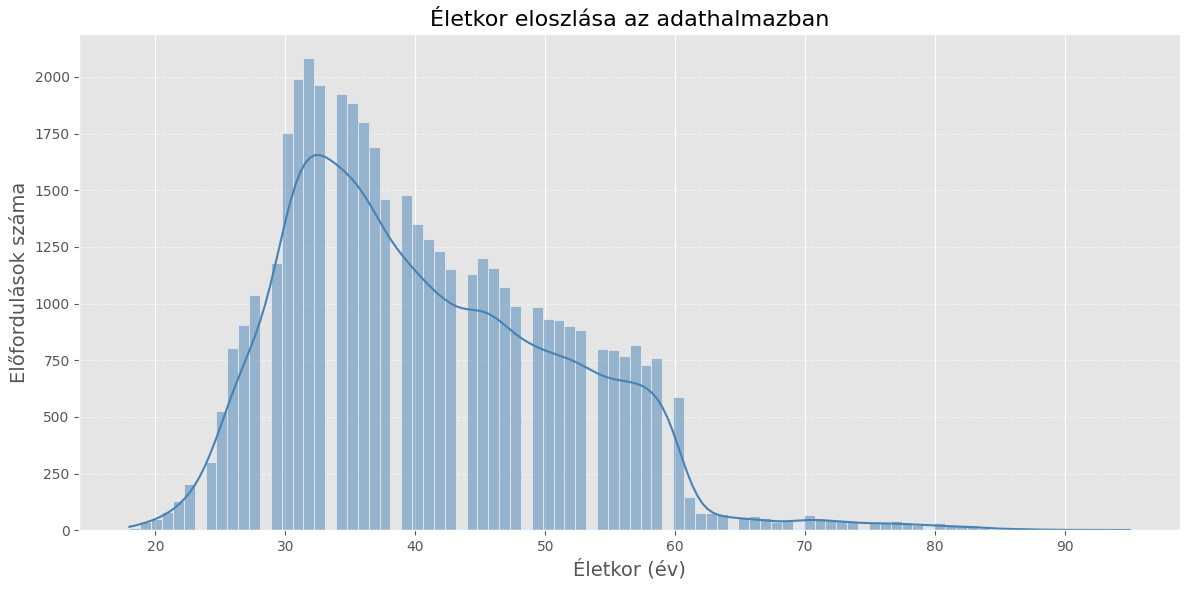

Átlagéletkor: 40.89 év
Medián életkor: 39.00 év
Legfiatalabb: 18 év
Legidősebb: 95 év


In [27]:
plt.style.use('ggplot')
sns.set_palette("Blues_d")
plt.figure(figsize=(12, 6))
ax = sns.histplot(data=X, x='age', kde=True, color='steelblue')
plt.title('Életkor eloszlása az adathalmazban', fontsize=16)
plt.xlabel('Életkor (év)', fontsize=14)
plt.ylabel('Előfordulások száma', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"Átlagéletkor: {X['age'].mean():.2f} év")
print(f"Medián életkor: {X['age'].median():.2f} év")
print(f"Legfiatalabb: {X['age'].min()} év")
print(f"Legidősebb: {X['age'].max()} év")

### balance

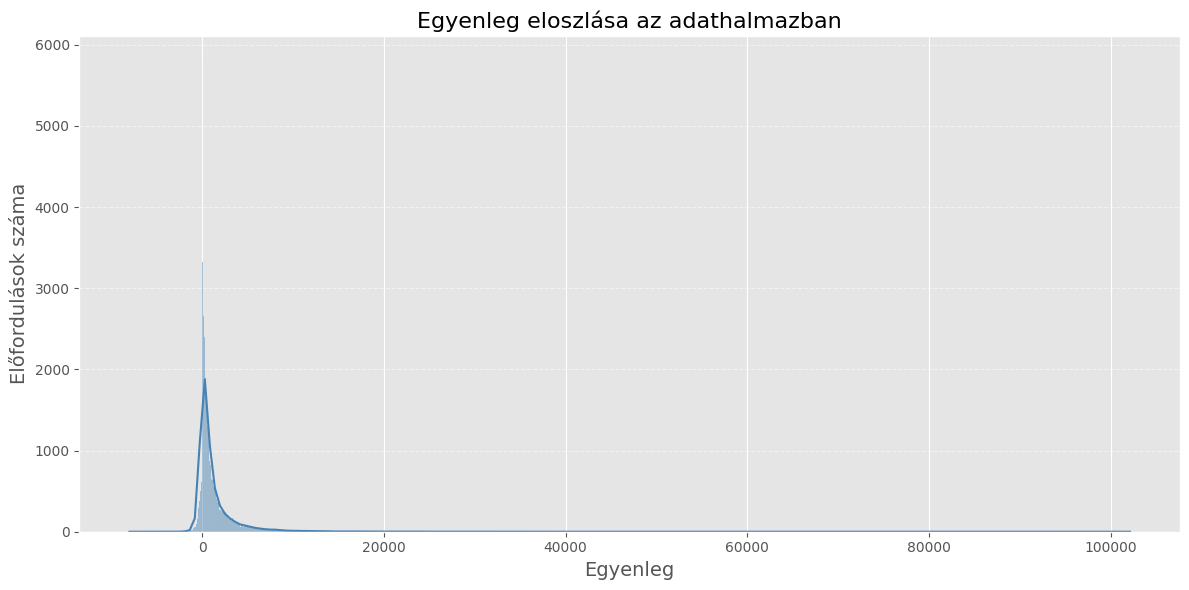

Átlag egyenleg: 1359.64
Medián egyenleg: 447.00
Legkisebb egyenleg: -8019
Legnagyobb egyenleg: 102127


In [28]:
plt.style.use('ggplot')
sns.set_palette("Blues_d")
plt.figure(figsize=(12, 6))
ax = sns.histplot(data=X, x='balance', kde=True, color='steelblue')
plt.title('Egyenleg eloszlása az adathalmazban', fontsize=16)
plt.xlabel('Egyenleg', fontsize=14)
plt.ylabel('Előfordulások száma', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print(f"Átlag egyenleg: {X['balance'].mean():.2f}")
print(f"Medián egyenleg: {X['balance'].median():.2f}")
print(f"Legkisebb egyenleg: {X['balance'].min()}")
print(f"Legnagyobb egyenleg: {X['balance'].max()}")

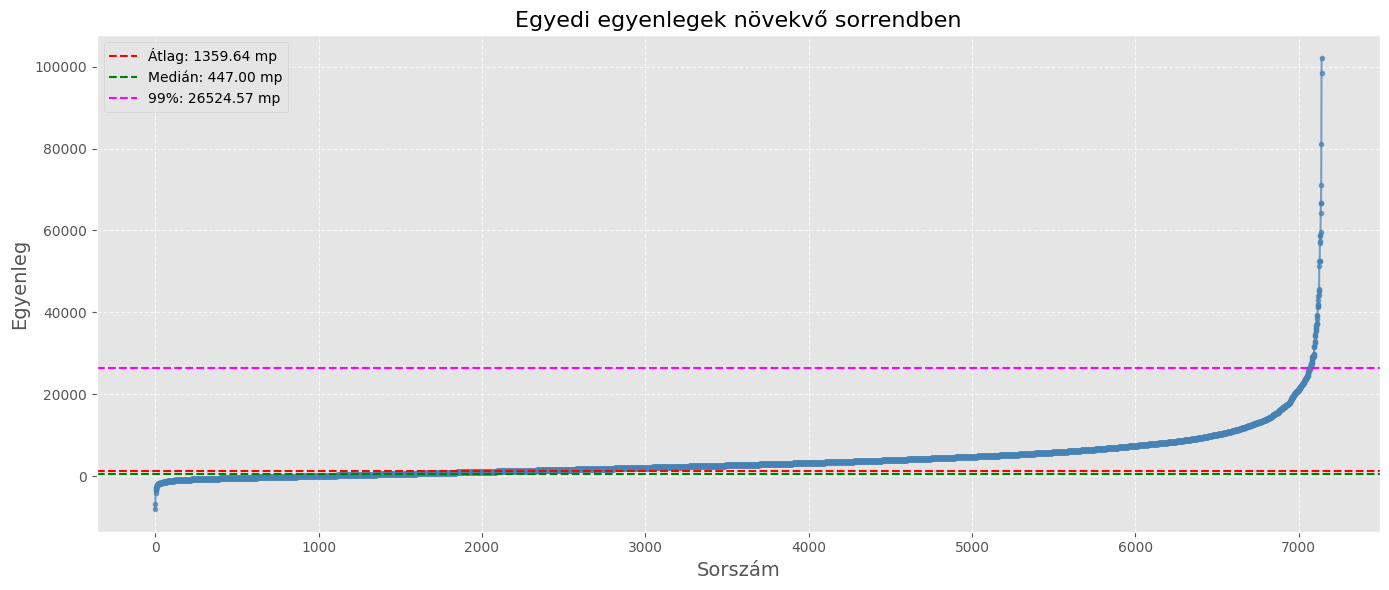

Egyedi egyenlegek száma: 7142
Legkisebb egyenleg: -8019
Legnagyobb egyenleg: 102127
Az adatok 99. percentilise: 26524.57


In [29]:
Xbal = np.sort(X.balance.unique())
X99 = np.percentile(Xbal, 99)
plt.style.use('ggplot')
plt.figure(figsize=(14, 6))
plt.plot(range(len(Xbal)), Xbal, marker='o', linestyle='-', color='steelblue', alpha=0.7, markersize=3)
plt.title('Egyedi egyenlegek növekvő sorrendben', fontsize=16)
plt.xlabel('Sorszám', fontsize=14)
plt.ylabel('Egyenleg', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=X['balance'].mean(), color='red', linestyle='--', label=f'Átlag: {X['balance'].mean():.2f} mp')
plt.axhline(y=X['balance'].median(), color='green', linestyle='--', label=f'Medián: {X['balance'].median():.2f} mp')
plt.axhline(y=X99, color='magenta', linestyle='--', label=f'99%: {X99:.2f} mp')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Egyedi egyenlegek száma: {len(Xbal)}")
print(f"Legkisebb egyenleg: {Xbal[0]}")
print(f"Legnagyobb egyenleg: {Xbal[-1]}")
print(f"Az adatok 99. percentilise: {X99:.2f}")

Az egyenlegekben vannak mindkét irányban kiugró értékek, de ezekhez nem nyúlok, mert ezek nem valószínű, hogy hibás adatok. Egyszerűen vannak ügyfelek, akiknek adósságai vannak és vannak ügyfelek akiknek sok a megtakarított pénze.

### campaign

Azt mutatja, hogy a jelenlegi kampányban hányszor kellett megkeresni az ügyfelet.

In [30]:
np.sort(X['campaign'].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 41, 43, 44, 46, 50, 51, 55, 58, 63])

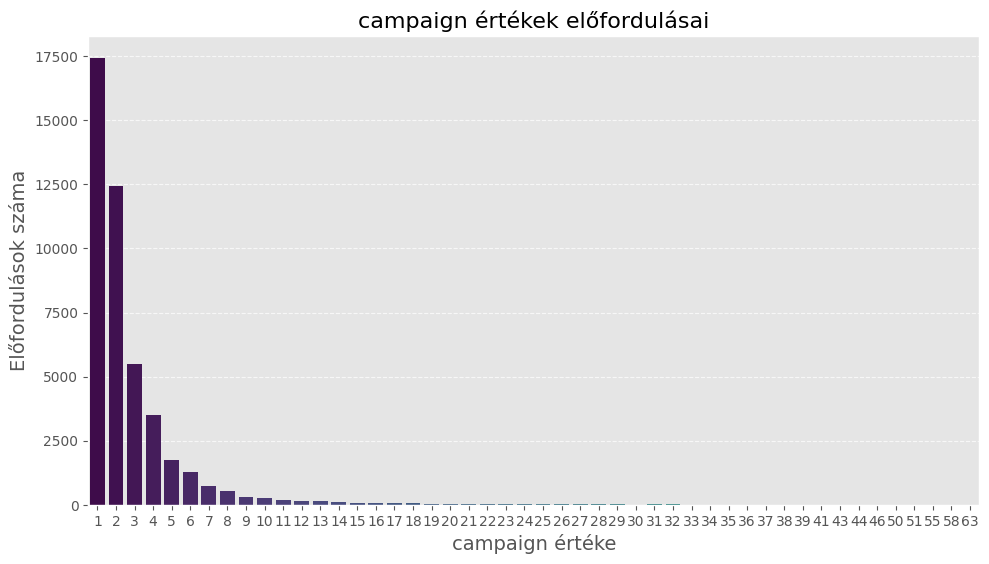

In [31]:
plt.style.use('ggplot')
sns.set_palette("Blues_d")
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=X, x='campaign', palette='viridis', hue='campaign', legend=False)
plt.title('campaign értékek előfordulásai', fontsize=16)
plt.xlabel('campaign értéke', fontsize=14)
plt.ylabel('Előfordulások száma', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

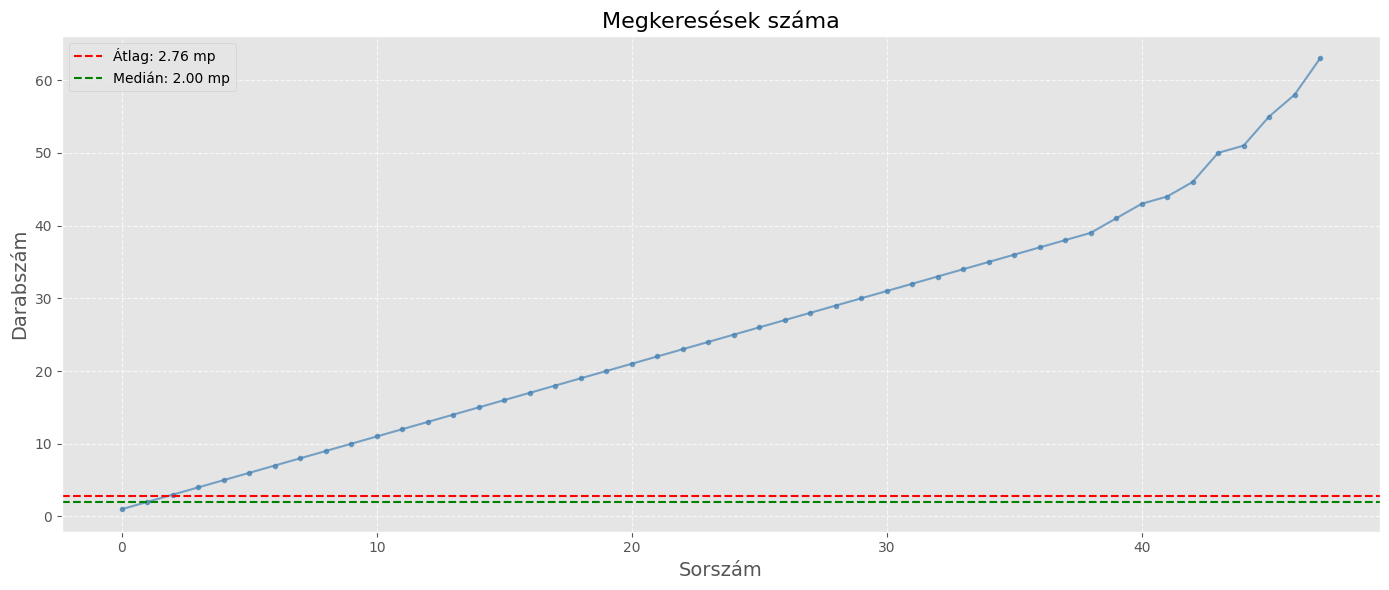

Előforduló különböző értékek: 48
Legkissebb: 1
Legnagyobb: 63


In [32]:
Xcmp = np.sort(X.campaign.unique())
plt.style.use('ggplot')
plt.figure(figsize=(14, 6))
plt.plot(range(len(Xcmp)), Xcmp, marker='o', linestyle='-', color='steelblue', alpha=0.7, markersize=3)
plt.title('Megkeresések száma', fontsize=16)
plt.xlabel('Sorszám', fontsize=14)
plt.ylabel('Darabszám', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=X['campaign'].mean(), color='red', linestyle='--', label=f'Átlag: {X["campaign"].mean():.2f} mp')
plt.axhline(y=X['campaign'].median(), color='green', linestyle='--', label=f'Medián: {X["campaign"].median():.2f} mp')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Előforduló különböző értékek: {len(Xcmp)}")
print(f"Legkissebb: {Xcmp[0]}")
print(f"Legnagyobb: {Xcmp[-1]}")

### pdays

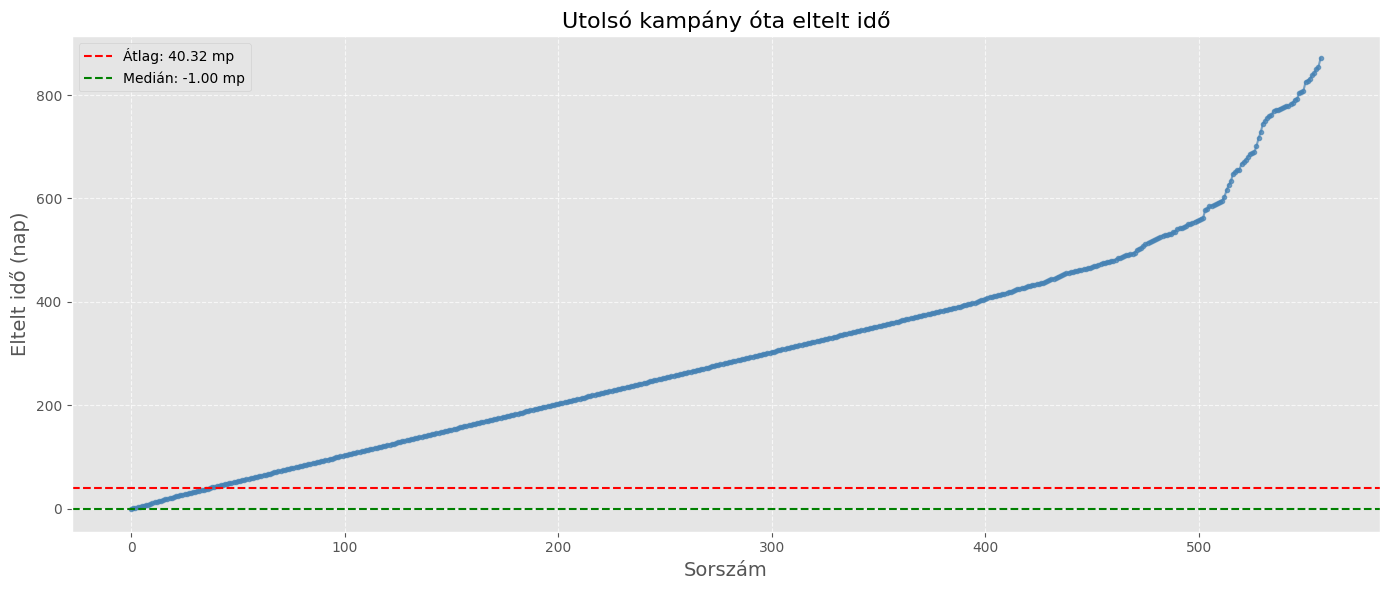

Utolsó kampány óta eltelt idő különböző értékei: 558
Legrövidebb: -1 nap
Leghosszabb: 871 nap


In [33]:
Xpdays = np.sort(X.pdays.unique())
plt.style.use('ggplot')
plt.figure(figsize=(14, 6))
plt.plot(range(len(Xpdays)), Xpdays, marker='o', linestyle='-', color='steelblue', alpha=0.7, markersize=3)
plt.title('Utolsó kampány óta eltelt idő', fontsize=16)
plt.xlabel('Sorszám', fontsize=14)
plt.ylabel('Eltelt idő (nap)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=X['pdays'].mean(), color='red', linestyle='--', label=f'Átlag: {X["pdays"].mean():.2f} mp')
plt.axhline(y=X['pdays'].median(), color='green', linestyle='--', label=f'Medián: {X["pdays"].median():.2f} mp')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Utolsó kampány óta eltelt idő különböző értékei: {len(Xpdays)}")
print(f"Legrövidebb: {Xpdays[0]} nap")
print(f"Leghosszabb: {Xpdays[-1]} nap")

In [34]:
negativ_pdays_darab = sum(X['pdays'] == -1)
osszes_sor = len(X)
szazalek = (negativ_pdays_darab / osszes_sor) * 100

print(f"Az -1 értékek száma: {negativ_pdays_darab}")
print(f"Összes sor száma: {osszes_sor}")
print(f"Százalék: {szazalek:.2f}%")

Az -1 értékek száma: 36699
Összes sor száma: 44923
Százalék: 81.69%


Ez a mező azt írja le, hogy ha az előző kampányban hívva volt az ügyfél, akkor mennyi idő telt el azóta. A -1 azt jelenti, hogy nem volt az ügyfél az előző kampányokban hívva. Mivel a previous mező azt jelenti, hogy az előző kampányokban hányszor hívtuk, ezért annak ezekben az esetekben 0-nak kellene lennie, ezt ellenőrzöm is.

In [35]:
X_not_contacted = X[X.pdays == -1]
X_not_contacted['previous'].max(), X_not_contacted['previous'].min()

(np.int64(0), np.int64(0))

### previous

Ez az oszlop azt mutatja meg, hogy hányszor lett megkeresve az ügyfél ez előtt a kampány előtt.

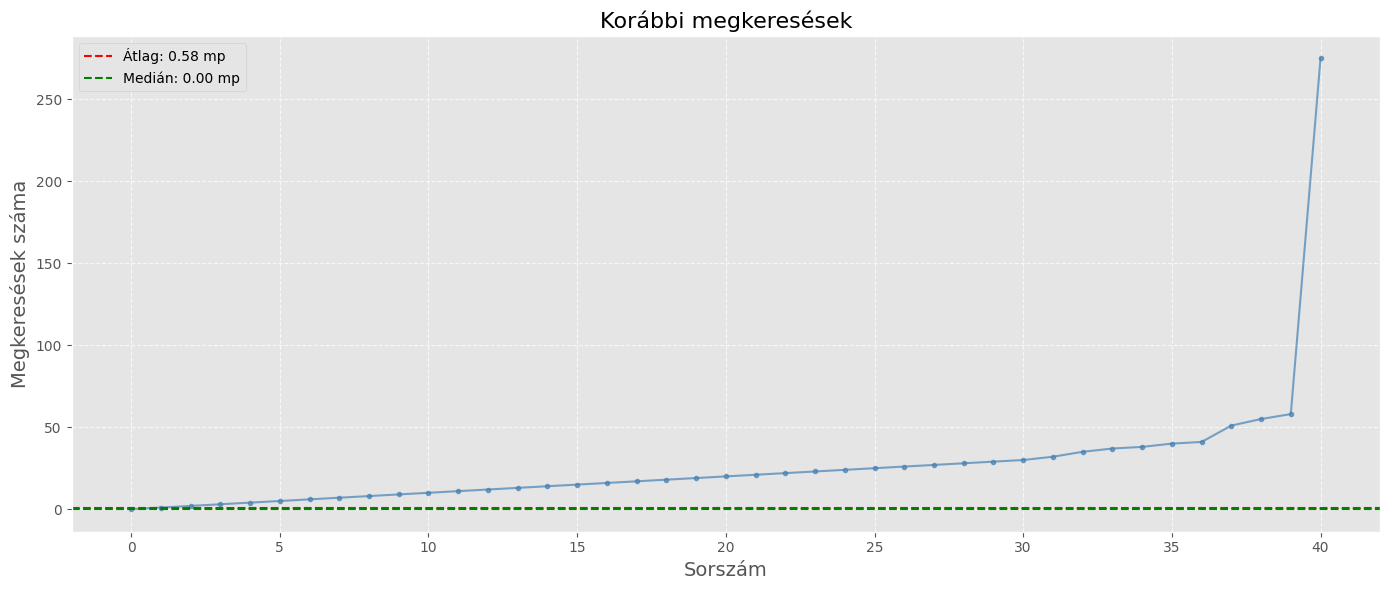

Különböző értékek: 41
Legkisebb: 0
Legnagyobb: 275


In [36]:
Xprev = np.sort(X.previous.unique())
plt.style.use('ggplot')
plt.figure(figsize=(14, 6))
plt.plot(range(len(Xprev)), Xprev, marker='o', linestyle='-', color='steelblue', alpha=0.7, markersize=3)
plt.title('Korábbi megkeresések', fontsize=16)
plt.xlabel('Sorszám', fontsize=14)
plt.ylabel('Megkeresések száma', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=X['previous'].mean(), color='red', linestyle='--', label=f'Átlag: {X["previous"].mean():.2f} mp')
plt.axhline(y=X['previous'].median(), color='green', linestyle='--', label=f'Medián: {X["previous"].median():.2f} mp')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Különböző értékek: {len(Xprev)}")
print(f"Legkisebb: {Xprev[0]}")
print(f"Legnagyobb: {Xprev[-1]}")

Ez nagyon érdekes, van egy olyan ügyfél, akit 275-ször is kerestünk már a korábbi kampányokban. Ez nagyon nagyon kiugró érték és csak egyszer fordul elő, ezért ezt outliernek tekintem és cserélem a leggyakrabban előforduló értékre abban a rekordban.

In [37]:
X.loc[X['previous'] == 275, 'previous'] = X['previous'].mode()[0]

Újra ellenőrzés, hogy minden a tervnek megfelelően lett módosítva.

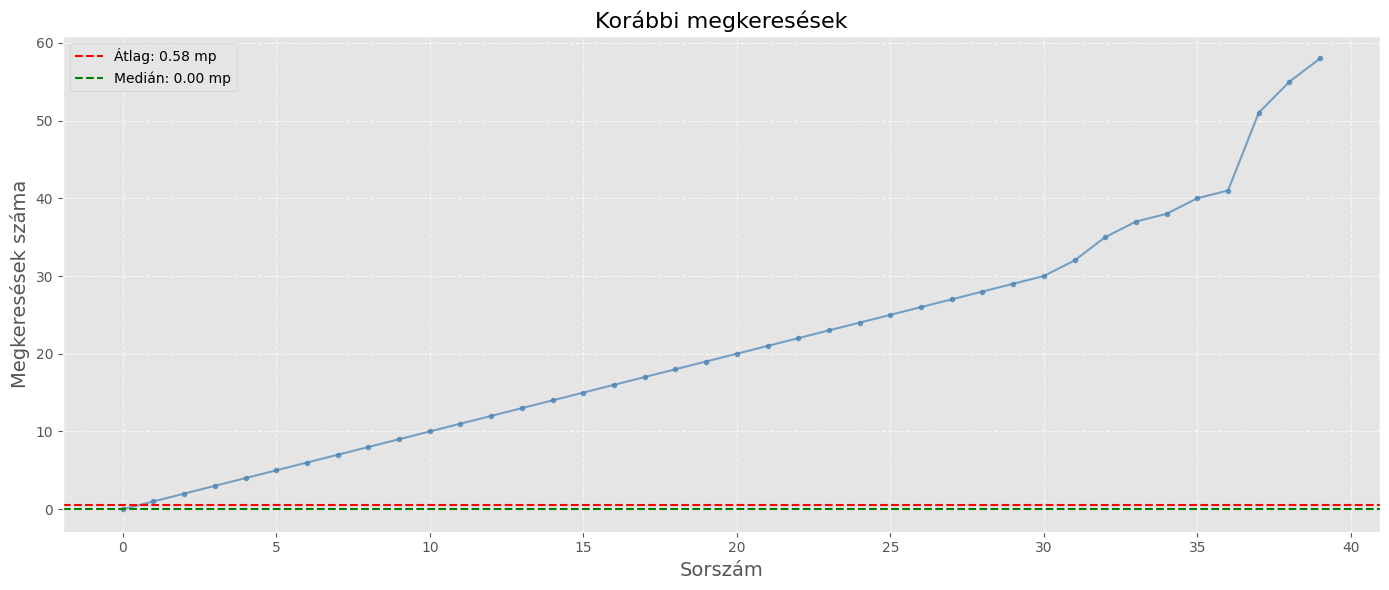

Különböző értékek: 40
Legkisebb: 0
Legnagyobb: 58


In [38]:
Xprev = np.sort(X.previous.unique())
plt.style.use('ggplot')
plt.figure(figsize=(14, 6))
plt.plot(range(len(Xprev)), Xprev, marker='o', linestyle='-', color='steelblue', alpha=0.7, markersize=3)
plt.title('Korábbi megkeresések', fontsize=16)
plt.xlabel('Sorszám', fontsize=14)
plt.ylabel('Megkeresések száma', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.axhline(y=X['previous'].mean(), color='red', linestyle='--', label=f'Átlag: {X["previous"].mean():.2f} mp')
plt.axhline(y=X['previous'].median(), color='green', linestyle='--', label=f'Medián: {X["previous"].median():.2f} mp')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Különböző értékek: {len(Xprev)}")
print(f"Legkisebb: {Xprev[0]}")
print(f"Legnagyobb: {Xprev[-1]}")

## Adatok átalakítása

Mivel a legtöbb adatunk kategórikus, ezért a többi adatot is megpróbálom kategórikusra alakítani.

### age

Itt az egyenlő szélességű vödör mellett döntöttem a korábban látott age eloszlás miatt. Az 5 vödör kialakítása gyakorlatilag próbálkozásos alapon ment, több szélességet is kipróbáltam, az 5 vödröt találtam a legmegfelelőbbnek.

In [39]:
age_bins = pd.cut(X.age, 5, labels=['young', 'early-mid-aged', 'middle-aged', 'late-mid-aged', 'elderly'], retbins=True)
X['age_category'] = age_bins[0].to_list()

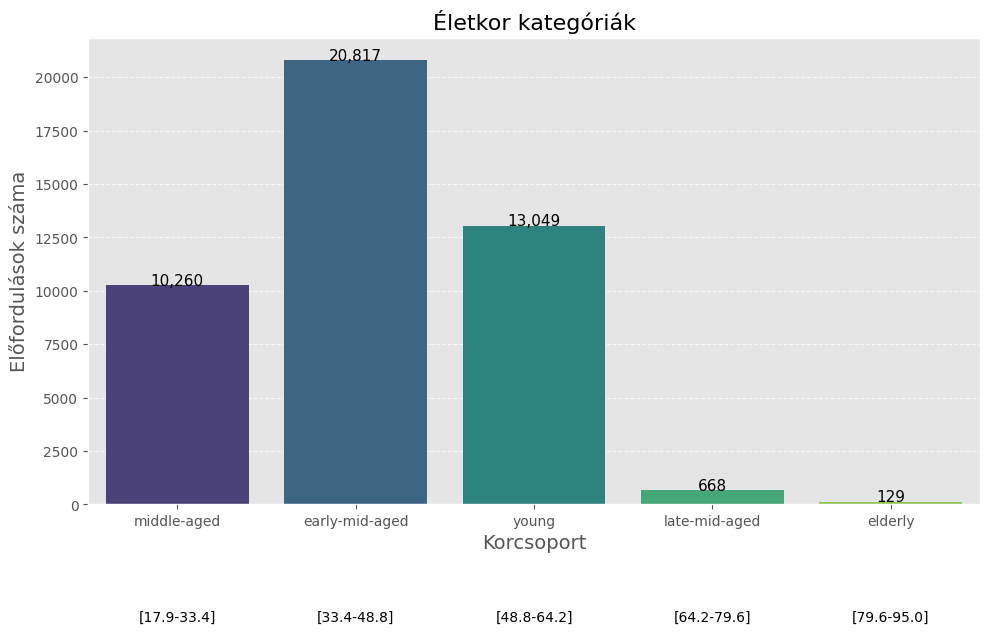

In [40]:
plt.style.use('ggplot')
sns.set_palette("Blues_d")
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=X, x='age_category', palette='viridis', hue='age_category', legend=False)
plt.title('Életkor kategóriák', fontsize=16)
plt.xlabel('Korcsoport', fontsize=14)
plt.ylabel('Előfordulások száma', fontsize=14)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1,
            f'{height:,.0f}',
            ha="center", fontsize=11)

for i, category in enumerate(sorted(X['age_category'].unique())):
    if i < len(age_bins[1])-1:
        label_text = f"[{age_bins[1][i]:.1f}-{age_bins[1][i+1]:.1f}]"
        ax.text(i, -0.25, label_text, ha='center', fontsize=10, transform=ax.get_xaxis_transform())

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

### balance

Itt a korábban látott balance eloszlás miatt nem tartom jó megoldásnak az egyenlő szélességű vödröket, mert lennének nagyon alacsony számosságú vödrök a kiugró egyenlegek miatt. Ezért itt az egyenlő mélységű vödröket fogom alkalmazni.

In [41]:
balance_bins = pd.qcut(X.balance, 5, labels=['bad', 'poor', 'normal', 'good', 'excellent'], retbins=True)
X['balance_category'] = balance_bins[0]

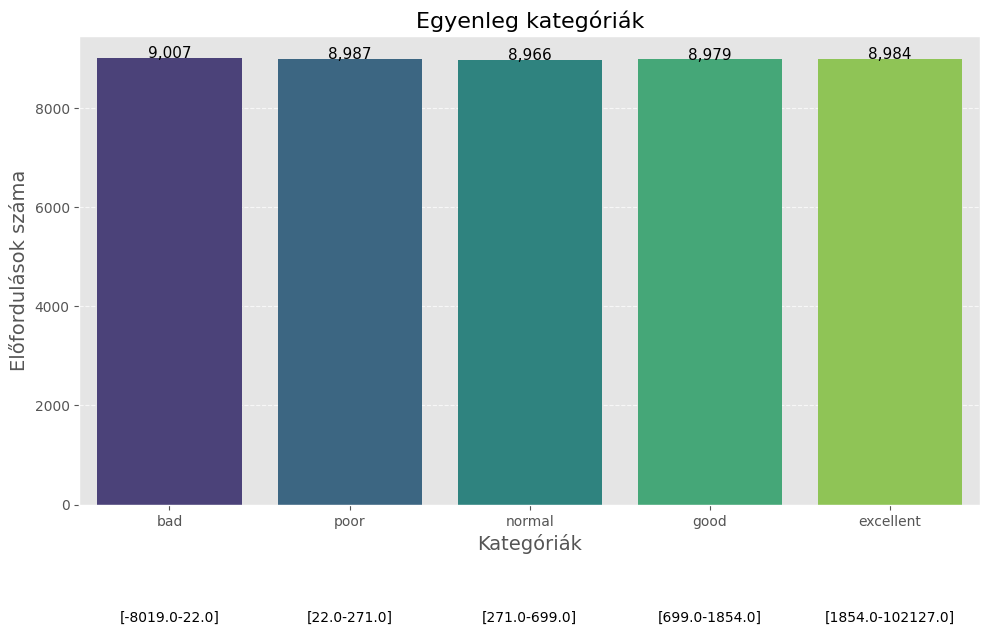

In [42]:
plt.style.use('ggplot')
sns.set_palette("Blues_d")
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=X, x='balance_category', palette='viridis', hue='balance_category', legend=False)
plt.title('Egyenleg kategóriák', fontsize=16)
plt.xlabel('Kategóriák', fontsize=14)
plt.ylabel('Előfordulások száma', fontsize=14)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1,
            f'{height:,.0f}',
            ha="center", fontsize=11)

for i, category in enumerate(sorted(X['balance_category'].unique())):
    if i < len(balance_bins[1])-1:
        label_text = f"[{balance_bins[1][i]:.1f}-{balance_bins[1][i+1]:.1f}]"
        ax.text(i, -0.25, label_text, ha='center', fontsize=10, transform=ax.get_xaxis_transform())

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

### day of month, month oszlopok

Ezek eleve kategóriák. A day of month 31 kategória, de ehhez azért nem nyúlok, mert szerintem nem mindegy, hogy a hónap első napján keresem meg az ügyfelet, amikor még nem kapott fizetést, vagy az utolsó napján, amikor már elköltötte azt.

In [43]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_month,month,campaign,pdays,previous,age_category,balance_category
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,middle-aged,excellent
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,early-mid-aged,poor
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,young,bad
3,47,blue-collar,married,secondary,no,1506,yes,no,unknown,5,may,1,-1,0,early-mid-aged,good
4,35,management,married,tertiary,no,231,yes,no,unknown,5,may,1,-1,0,early-mid-aged,poor


### pdays

Ez a mező érdekes, mert a -1-nek teljesen más jelentése van, mint az összes többi értéknek. A -1 azt jelenti, hogy a korábbi kampányokban még nem kerestük, míg a 0-nál nagyobb értékek azt jelentik, hogy hány nap telt el mióta az előző kampányban kerestük. Ezért amikor kategóriákra alakítom, a -1-egy külön kategóriát kap.

In [44]:
def pdays_kategoriak(pdays):
    if pdays == -1:
        return 0  # nem volt megkeresés
    elif pdays < 100:
        return 1  # kevesbb mint 100 nap
    elif pdays < 200:
        return 2  # 100-200 nap
    elif pdays < 300:
        return 3  # 200-300 nap
    elif pdays < 400:
        return 4  # 300-400 nap
    else:
        return 5  # 400+

In [45]:
X['pdays_category'] = X['pdays'].apply(pdays_kategoriak)

In [46]:
X.head()

,age,job,marital,education,default,balance,housing,loan,contact,day_of_month,month,campaign,pdays,previous,age_category,balance_category,pdays_category
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,middle-aged,excellent,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,early-mid-aged,poor,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,young,bad,0
3,47,blue-collar,married,secondary,no,1506,yes,no,unknown,5,may,1,-1,0,early-mid-aged,good,0
4,35,management,married,tertiary,no,231,yes,no,unknown,5,may,1,-1,0,early-mid-aged,poor,0


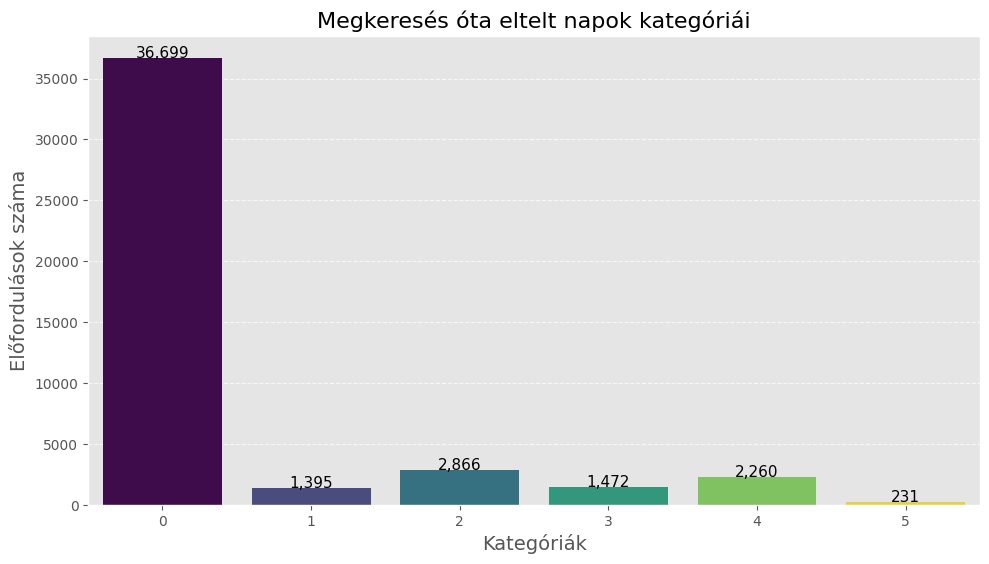

In [47]:
plt.style.use('ggplot')
sns.set_palette("Blues_d")
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=X, x='pdays_category', palette='viridis', hue='pdays_category', legend=False)
plt.title('Megkeresés óta eltelt napok kategóriái', fontsize=16)
plt.xlabel('Kategóriák', fontsize=14)
plt.ylabel('Előfordulások száma', fontsize=14)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1,
            f'{height:,.0f}',
            ha="center", fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

### campaign és previous

Ezek tulajdonképpen kategóriák, csak sok kategória van. Ez nemtudom, hogy későbbiekben mekkora gondot okoz, de egyelőre nem módosítom őket. Ezek ugyan azt az értéket fejezik ki (hányszor kerestük meg korábbi kampányban és hányszor a jelenlegiben), így remélem megfelelően lehet majd vele dolgozni.

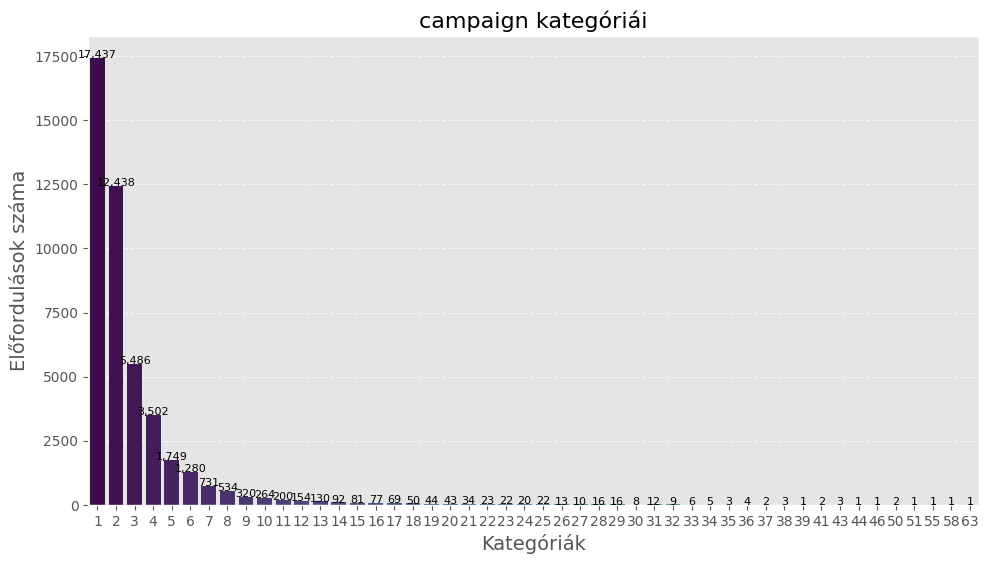

In [48]:
plt.style.use('ggplot')
sns.set_palette("Blues_d")
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=X, x='campaign', palette='viridis', hue='campaign', legend=False)
plt.title('campaign kategóriái', fontsize=16)
plt.xlabel('Kategóriák', fontsize=14)
plt.ylabel('Előfordulások száma', fontsize=14)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1,
            f'{height:,.0f}',
            ha="center", fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

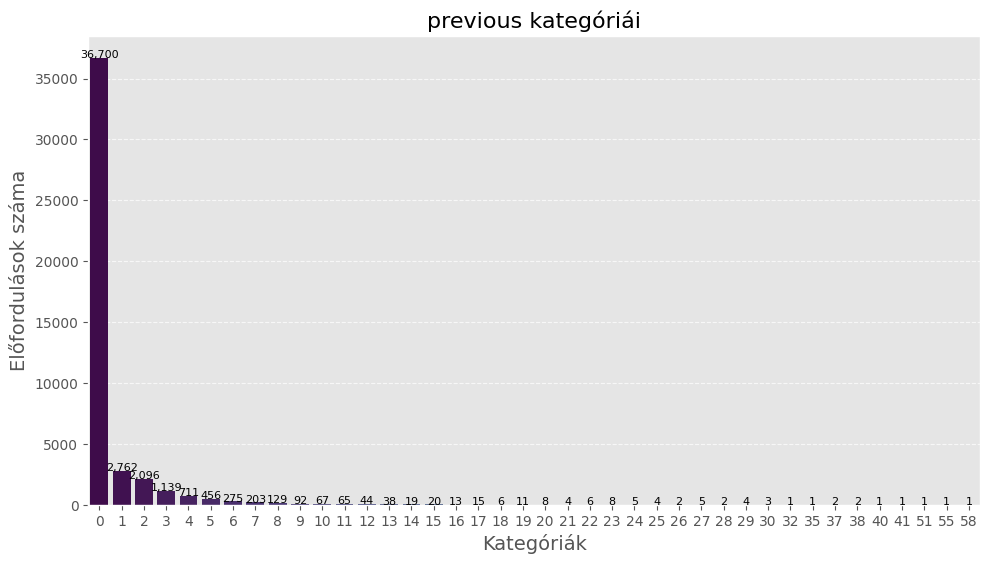

In [49]:
plt.style.use('ggplot')
sns.set_palette("Blues_d")
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=X, x='previous', palette='viridis', hue='previous', legend=False)
plt.title('previous kategóriái', fontsize=16)
plt.xlabel('Kategóriák', fontsize=14)
plt.ylabel('Előfordulások száma', fontsize=14)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 0.1,
            f'{height:,.0f}',
            ha="center", fontsize=8)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()

## Nem kategórikus adatok törlése

Miután már minden kategórikusra lett állítva, ezekre nincs szükség.

In [50]:
Xcat = X.copy()
Xcat.drop(columns=['age', 'balance', 'pdays'], inplace=True)
Xcat.head()

,job,marital,education,default,housing,loan,contact,day_of_month,month,campaign,previous,age_category,balance_category,pdays_category
0,management,married,tertiary,no,yes,no,unknown,5,may,1,0,middle-aged,excellent,0
1,technician,single,secondary,no,yes,no,unknown,5,may,1,0,early-mid-aged,poor,0
2,entrepreneur,married,secondary,no,yes,yes,unknown,5,may,1,0,young,bad,0
3,blue-collar,married,secondary,no,yes,no,unknown,5,may,1,0,early-mid-aged,good,0
4,management,married,tertiary,no,yes,no,unknown,5,may,1,0,early-mid-aged,poor,0


## Kategórikus adatok numerikussá alakítása

### job, marital, default, housing, loan, contact, month

Itt one-hot-encoding-ot használok, mert az egyes katgóriák közt nem lehet sorrendet felállítani.

In [51]:
onehot_encoder = preprocessing.OneHotEncoder()

In [52]:
onehot_encoder = preprocessing.OneHotEncoder(sparse_output=False)
encoded_col = onehot_encoder.fit_transform(Xcat[['job']])
feature_names = onehot_encoder.get_feature_names_out(['job'])
encoded_df = pd.DataFrame(encoded_col, columns=feature_names)
Xcat_encoded = pd.concat([Xcat.drop('job', axis=1), encoded_df], axis=1)

In [53]:
onehot_encoder = preprocessing.OneHotEncoder(sparse_output=False)
encoded_col = onehot_encoder.fit_transform(Xcat[['marital']])
feature_names = onehot_encoder.get_feature_names_out(['marital'])
encoded_df = pd.DataFrame(encoded_col, columns=feature_names)
Xcat_encoded = pd.concat([Xcat_encoded.drop('marital', axis=1), encoded_df], axis=1)

In [54]:
onehot_encoder = preprocessing.OneHotEncoder(sparse_output=False)
encoded_col = onehot_encoder.fit_transform(Xcat[['default']])
feature_names = onehot_encoder.get_feature_names_out(['default'])
encoded_df = pd.DataFrame(encoded_col, columns=feature_names)
Xcat_encoded = pd.concat([Xcat_encoded.drop('default', axis=1), encoded_df], axis=1)

In [55]:
onehot_encoder = preprocessing.OneHotEncoder(sparse_output=False)
encoded_col = onehot_encoder.fit_transform(Xcat[['housing']])
feature_names = onehot_encoder.get_feature_names_out(['housing'])
encoded_df = pd.DataFrame(encoded_col, columns=feature_names)
Xcat_encoded = pd.concat([Xcat_encoded.drop('housing', axis=1), encoded_df], axis=1)

In [56]:
onehot_encoder = preprocessing.OneHotEncoder(sparse_output=False)
encoded_col = onehot_encoder.fit_transform(Xcat[['loan']])
feature_names = onehot_encoder.get_feature_names_out(['loan'])
encoded_df = pd.DataFrame(encoded_col, columns=feature_names)
Xcat_encoded = pd.concat([Xcat_encoded.drop('loan', axis=1), encoded_df], axis=1)

In [57]:
onehot_encoder = preprocessing.OneHotEncoder(sparse_output=False)
encoded_col = onehot_encoder.fit_transform(Xcat[['contact']])
feature_names = onehot_encoder.get_feature_names_out(['contact'])
encoded_df = pd.DataFrame(encoded_col, columns=feature_names)
Xcat_encoded = pd.concat([Xcat_encoded.drop('contact', axis=1), encoded_df], axis=1)

In [58]:
onehot_encoder = preprocessing.OneHotEncoder(sparse_output=False)
encoded_col = onehot_encoder.fit_transform(Xcat[['month']])
feature_names = onehot_encoder.get_feature_names_out(['month'])
encoded_df = pd.DataFrame(encoded_col, columns=feature_names)
Xcat_encoded = pd.concat([Xcat_encoded.drop('month', axis=1), encoded_df], axis=1)

### education, age_category, balance_category

Az education esetében felállítható sorrend és valószínűleg hatással van a keresetre és ezáltal a hajlandóságra az új termék iránt. Ezért ezt nem one-hot, hanem ordinális kódolást használok.

In [59]:
Xcat_encoded.education.unique()

array(['tertiary', 'secondary', 'primary'], dtype=object)

In [60]:
ordinal_mapper = {'primary':'1', 'secondary':'2', 'tertiary':'3'}
Xcat_encoded['education_category'] = Xcat_encoded['education'].replace(ordinal_mapper)
Xcat_encoded['education_category'] = pd.to_numeric(Xcat_encoded['education_category'])
Xcat_encoded = Xcat_encoded.drop('education', axis=1)

In [61]:
Xcat_encoded.age_category.unique()

array(['middle-aged', 'early-mid-aged', 'young', 'late-mid-aged',
       'elderly'], dtype=object)

In [62]:
ordinal_mapper = {'young':'1', 'early-mid-aged':'2', 'middle-aged':'3', 'late-mid-aged':'4', 'elderly':'5'}
Xcat_encoded['age_cat'] = Xcat_encoded['age_category'].replace(ordinal_mapper)
Xcat_encoded['age_cat'] = pd.to_numeric(Xcat_encoded['age_cat'])
Xcat_encoded = Xcat_encoded.drop('age_category', axis=1)

In [63]:
Xcat_encoded.balance_category.unique()

['excellent', 'poor', 'bad', 'good', 'normal']
Categories (5, object): ['bad' < 'poor' < 'normal' < 'good' < 'excellent']

In [64]:
ordinal_mapper = {'bad':'1', 'poor':'2', 'normal':'3', 'good':'4', 'excellent':'5'}
Xcat_encoded['balance_cat'] = Xcat_encoded['balance_category'].replace(ordinal_mapper)
Xcat_encoded['balance_cat'] = pd.to_numeric(Xcat_encoded['balance_cat'])
Xcat_encoded = Xcat_encoded.drop('balance_category', axis=1)

/var/folders/p9/yfdwydy169s3mz1hd23bwrtw0000gn/T/ipykernel_11701/1307444060.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  Xcat_encoded['balance_cat'] = Xcat_encoded['balance_category'].replace(ordinal_mapper)


In [65]:
Xcat_encoded.head()

,day_of_month,campaign,previous,pdays_category,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,education_category,age_cat,balance_cat
0,5,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,3,5
1,5,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,2,2
2,5,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,1,1
3,5,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2,2,4
4,5,1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3,2,2


In [69]:
feature_cimkek = list(Xcat_encoded.columns)
print(feature_cimkek)

['day_of_month', 'campaign', 'previous', 'pdays_category', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_married', 'marital_single', 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep', 'education_category', 'age_cat', 'balance_cat']


In [70]:
one_hot_cols = ['job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_married', 'marital_single', 'default_no', 'default_yes', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct', 'month_sep']
ordinal_cols = ['day_of_month', 'campaign', 'previous', 'pdays_category', 'education_category', 'age_cat', 'balance_cat']

df_onehot = Xcat_encoded[one_hot_cols]
df_ordinal = Xcat_encoded[ordinal_cols]